In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import numpy as np
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from preeya_co_obstacle import behavior_co_obs as bmi_b
from preeya_co_obstacle import data_for_v as preeyacode
from preeya_co_obstacle import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [3]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = home_dir
data_path = os.path.join(data_dir, 'for_v_v4.pkl')
print(os.path.exists(data_path))
data = pickle.load(open(data_path))

True


In [4]:
data.keys()

[(4378, 'decC'),
 (4382, 'decW'),
 (4377, 'trial_ix'),
 (4377, 'dec_KG'),
 (4377, 'cursor_state'),
 (4378, 'decW'),
 (4378, 'decQ'),
 (4378, 'dec_KG'),
 (4378, 'target_index'),
 (4377, 'decC'),
 (4378, 'trial_ix'),
 (4377, 'decQ'),
 (4377, 'neural_push'),
 (4377, 'binned_spk_cnts'),
 (4378, 'obstacle_size'),
 (4382, 'decQ'),
 (4382, 'dec_KG'),
 (4382, 'decF'),
 (4378, 'cursor_state'),
 (4382, 'binned_spk_cnts'),
 (4378, 'binned_spk_cnts_60Hz'),
 (4378, 'decA'),
 (4382, 'target_pos'),
 (4377, 'decF'),
 (4382, 'decC'),
 'task_entries',
 (4382, 'target_index'),
 (4378, 'cursor_pos'),
 (4382, 'binned_spk_cnts_60Hz'),
 (4377, 'decA'),
 (4377, 'binned_spk_cnts_60Hz'),
 (4377, 'target_index'),
 (4382, 'trial_ix'),
 (4378, 'decF'),
 (4377, 'cursor_pos'),
 (4382, 'neural_push'),
 (4382, 'obstacle_location'),
 (4382, 'obstacle_size'),
 (4377, 'target_pos'),
 (4382, 'cursor_pos'),
 (4377, 'decW'),
 (4378, 'neural_push'),
 (4382, 'cursor_state'),
 (4378, 'target_pos'),
 (4378, 'binned_spk_cnts'),


In [ ]:
#distinct data types: 
# decC
# decW
# decQ
# dec_KG
# trial_ix
# target_index
# target_pos
#
# cursor_state
# neural_push
# binned_spk_cnts
# binned_spk_cnts_60Hz

# obstacle_size
# shape: num_trials x 1
# each trial is either 2 or 3
#
# obstacle_location
# shape: num_trials x 1
# each trial is either 2 or 3


In [8]:
#Map between Task Code (tc) and Task {'co', 'obs'}
task2tc = {'co':data['task_entries'][0], 'obs':data['task_entries'][1]}
tc_list = [item for sublist in data['task_entries'] for item in sublist]
tc2task = {}
for k,v_list in task2tc.items():
    for v in v_list:
        tc2task[v] = k
print(tc_list)
print(tc2task)

[4377, 4378, 4382]
{4377: 'co', 4378: 'obs', 4382: 'obs'}


In [6]:
data.keys()

[(4378, 'decC'),
 (4382, 'decW'),
 (4377, 'trial_ix'),
 (4377, 'dec_KG'),
 (4377, 'cursor_state'),
 (4378, 'decW'),
 (4378, 'decQ'),
 (4378, 'dec_KG'),
 (4378, 'target_index'),
 (4377, 'decC'),
 (4378, 'trial_ix'),
 (4377, 'decQ'),
 (4377, 'neural_push'),
 (4377, 'binned_spk_cnts'),
 (4378, 'obstacle_size'),
 (4382, 'decQ'),
 (4382, 'dec_KG'),
 (4382, 'decF'),
 (4378, 'cursor_state'),
 (4382, 'binned_spk_cnts'),
 (4378, 'binned_spk_cnts_60Hz'),
 (4378, 'decA'),
 (4382, 'target_pos'),
 (4377, 'decF'),
 (4382, 'decC'),
 'task_entries',
 (4382, 'target_index'),
 (4378, 'cursor_pos'),
 (4382, 'binned_spk_cnts_60Hz'),
 (4377, 'decA'),
 (4377, 'binned_spk_cnts_60Hz'),
 (4377, 'target_index'),
 (4382, 'trial_ix'),
 (4378, 'decF'),
 (4377, 'cursor_pos'),
 (4382, 'neural_push'),
 (4382, 'obstacle_location'),
 (4382, 'obstacle_size'),
 (4377, 'target_pos'),
 (4382, 'cursor_pos'),
 (4377, 'decW'),
 (4378, 'neural_push'),
 (4382, 'cursor_state'),
 (4378, 'target_pos'),
 (4378, 'binned_spk_cnts'),


In [9]:
tc = task2tc['obs'][0]
data[tc, 'obstacle_size'].shape

(101L, 1L)

In [15]:
num_targets = 8
tc_meta = {}
tc_trials = {}
task2data_list = {}
task2data_list['co'] = ['cursor_pos', 'cursor_state', 'neural_push',  'binned_spk_cnts']
task2data_list['obs'] = ['cursor_pos', 'cursor_state', 'neural_push',  'binned_spk_cnts', 'obstacle_size', 'obstacle_location']
target_color = ['maroon', 'orangered', 'darkgoldenrod', 'olivedrab', 'teal', 'steelblue', 'midnightblue', 'darkmagenta']
sample_period = 0.1 #seconds
target_hold_time = 0.2 #seconds

for tc in tc_list: 
    task = tc2task[tc]
    tc_meta[tc] = {}
    tc_trials[tc] = []
    
    num_trials = int(data[tc, 'trial_ix'].max()+1)
    ttype = np.array([data[tc, 'target_index'][np.where(data[tc, 'trial_ix'] == i_trial)[0][0]] for i_trial in range(num_trials)]).astype(int)
    target_pos = np.array([data[tc, 'target_pos'][np.where(data[tc, 'target_index'] == i_target)[0][0], :] for i_target in range(num_targets)])
    num_trials_per_target = [np.sum(ttype==i) for i in range(num_targets)]
    target_trial_idxs = {}
    for i in range(num_targets):
        target_trial_idxs[i] = np.where(ttype==i)[0]
    if task == 'obs':
        #obs_pos: one obs position per target
        obs_pos = np.array([data[tc, 'obstacle_location'][target_trial_idxs[i][0], :] for i in range(num_targets)])
        #obs_size_per_target: for each target, an array of obstacle size
        obs_size_per_target_trial = [data[tc, 'obstacle_size'][target_trial_idxs[i],:] for i in range(num_targets)]
    #for each target, what are the obstacle sizes
    
    #Loop trials: 
    for i in range(num_trials):
        trial_data = {}
        for d in task2data_list[tc2task[tc]]:
            trial_data[d] = np.array(data[tc, d][i])
        #time of trial: 
        trial_data['len'] = sample_period*trial_data['cursor_pos'].shape[0]
        tc_trials[tc].append(trial_data)
    
    #ASSIGN:
    tc_meta[tc]['task'] = tc2task[tc]
    tc_meta[tc]['ttype'] = ttype
    tc_meta[tc]['target_pos'] = target_pos
    if task == 'obs':
        tc_meta[tc]['obs_pos'] = obs_pos
        tc_meta[tc]['obs_size_per_target_trial'] = obs_size_per_target_trial
    tc_meta[tc]['num_trials'] = num_trials
    tc_meta[tc]['num_trials_per_target'] = num_trials_per_target
    tc_meta[tc]['target_trial_idxs'] = target_trial_idxs
    tc_meta[tc]['sample_period'] = sample_period
    tc_meta[tc]['target_hold'] = target_hold_time
    

In [28]:
tc_meta[tc]['ttype']

array([5, 6, 4, 7, 1, 3, 6, 2, 2, 0, 1, 0, 5, 3, 7, 4, 6, 0, 5, 2, 7, 5,
       4, 0, 4, 1, 3, 3, 7, 1, 2, 6, 6, 7, 5, 1, 7, 0, 2, 3, 4, 5, 6, 2,
       3, 1, 4, 0, 2, 2, 0, 0, 7, 3, 4, 3, 1, 1, 7, 5, 6, 6, 5, 4, 5, 2,
       7, 0, 1, 4, 3, 7, 2, 3, 4, 6, 0, 1, 5, 6, 3, 7, 5, 6, 2, 6, 2, 0,
       7, 4, 4, 0, 5, 3, 1, 1, 2, 0, 4, 7, 2])

In [16]:
tc = task2tc['obs'][0]
tc_meta[tc]['obs_size_per_target_trial'][0]

array([[2.],
       [3.],
       [2.],
       [3.],
       [2.],
       [3.],
       [2.],
       [3.],
       [2.],
       [3.],
       [3.],
       [2.],
       [3.]])

<IPython.core.display.Javascript object>


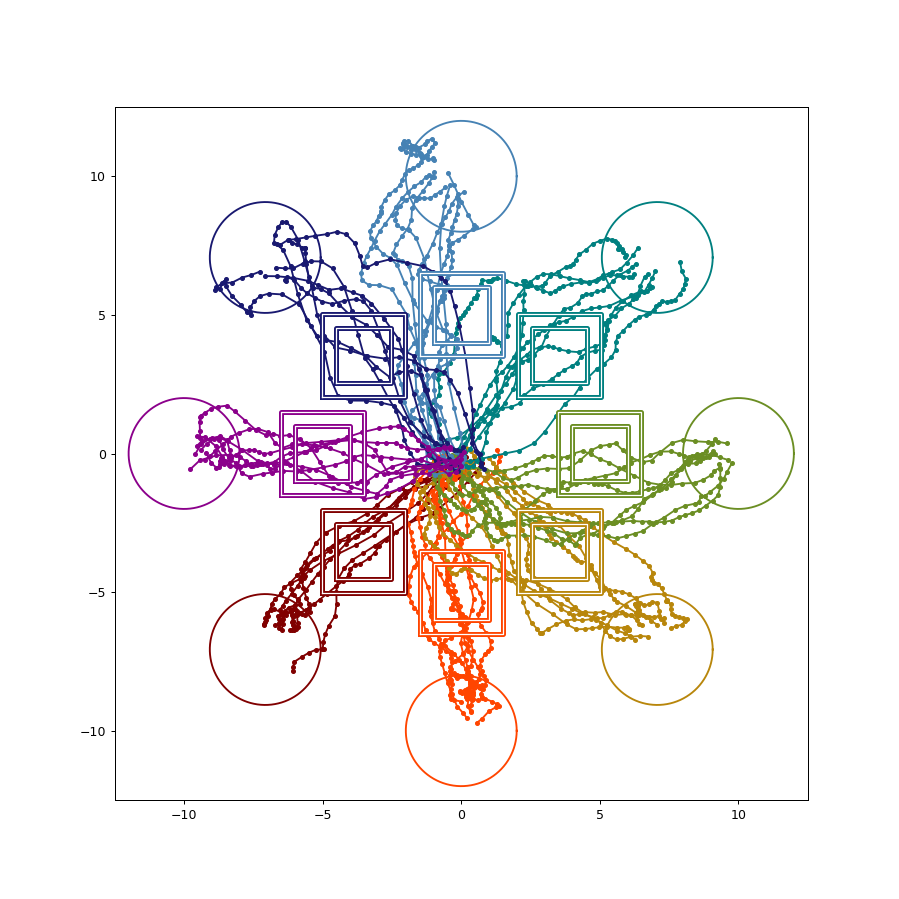

[-7.07106781 -7.07106781]
[-1.8369702e-15 -1.0000000e+01]
[ 7.07106781 -7.07106781]
[10.  0.]
[7.07106781 7.07106781]
[6.123234e-16 1.000000e+01]
[-7.07106781  7.07106781]
[-1.0000000e+01  1.2246468e-15]


<IPython.core.display.Javascript object>


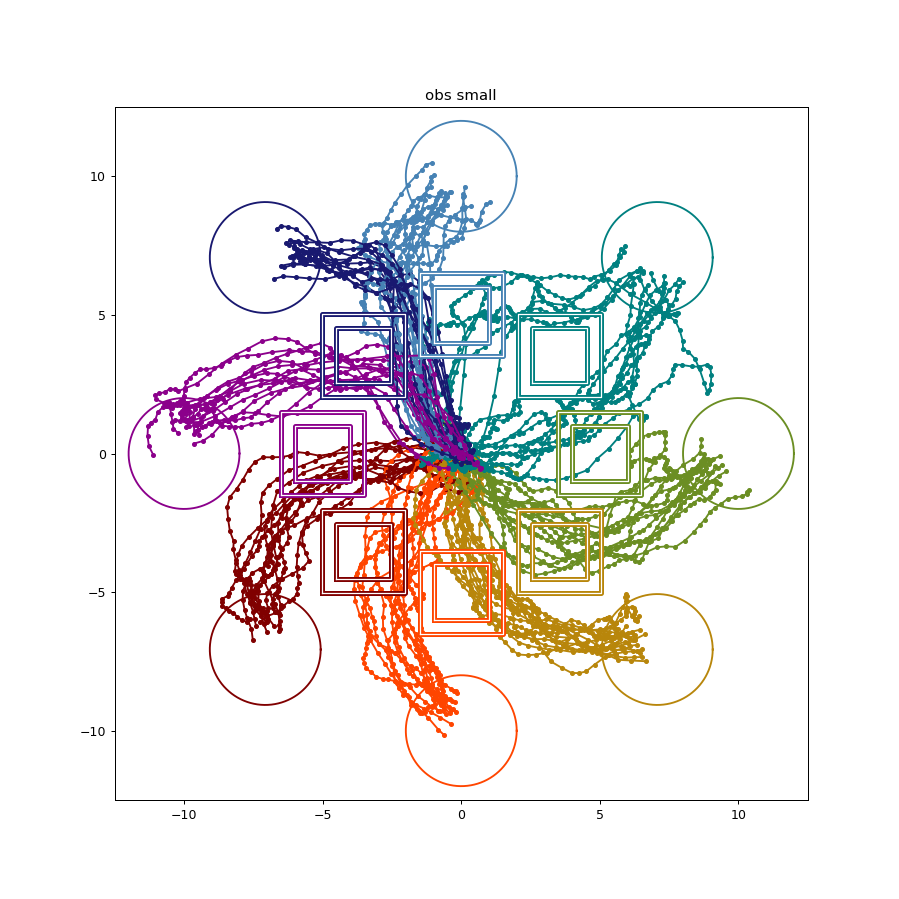

('small', array([ 0,  2,  4,  6,  8, 11], dtype=int64))
('small', array([ 1,  3,  4,  7,  9, 10], dtype=int64))
('small', array([ 0,  2,  4,  7,  9, 11, 13], dtype=int64))
('small', array([ 0,  2,  5,  7,  8, 11], dtype=int64))
('small', array([ 1,  2,  5,  7,  9, 10, 12], dtype=int64))
('small', array([ 1,  3,  4,  6,  9, 11], dtype=int64))
('small', array([ 0,  3,  5,  6,  9, 11], dtype=int64))
('small', array([ 0,  3,  5,  7,  8, 11, 12], dtype=int64))
('small', array([ 0,  2,  4,  6,  8, 11, 13], dtype=int64))
('small', array([ 1,  3,  4,  7,  9, 10, 13, 14], dtype=int64))
('small', array([ 0,  2,  4,  7,  9, 11, 13, 14], dtype=int64))
('small', array([ 0,  2,  5,  7,  8, 11, 13, 14], dtype=int64))
('small', array([ 1,  2,  5,  7,  9, 10, 12], dtype=int64))
('small', array([ 1,  3,  4,  6,  9, 11, 13, 14], dtype=int64))
('small', array([ 0,  3,  5,  6,  9, 11, 12], dtype=int64))
('small', array([ 0,  3,  5,  7,  8, 11, 12], dtype=int64))
[-7.07106781 -7.07106781]
[-1.8369702e-15 -1

<IPython.core.display.Javascript object>


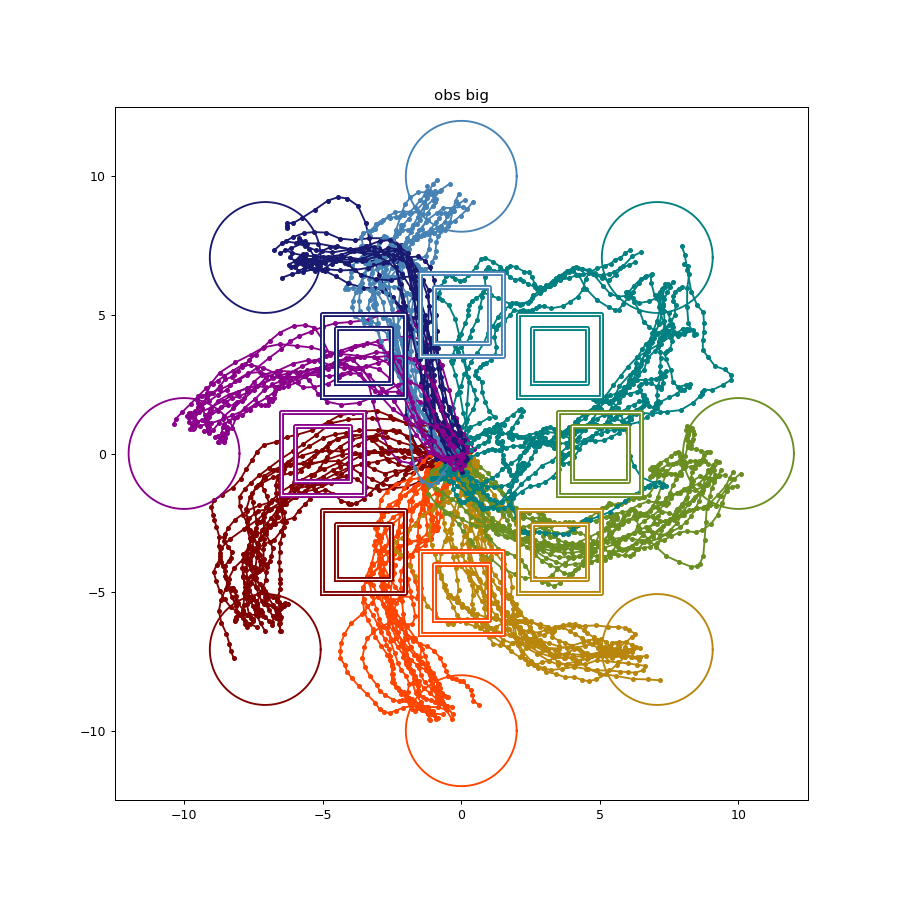

('big', array([ 1,  3,  5,  7,  9, 10, 12], dtype=int64))
('big', array([ 0,  2,  5,  6,  8, 11], dtype=int64))
('big', array([ 1,  3,  5,  6,  8, 10, 12], dtype=int64))
('big', array([ 1,  3,  4,  6,  9, 10], dtype=int64))
('big', array([ 0,  3,  4,  6,  8, 11], dtype=int64))
('big', array([ 0,  2,  5,  7,  8, 10], dtype=int64))
('big', array([ 1,  2,  4,  7,  8, 10], dtype=int64))
('big', array([ 1,  2,  4,  6,  9, 10], dtype=int64))
('big', array([ 1,  3,  5,  7,  9, 10, 12, 14], dtype=int64))
('big', array([ 0,  2,  5,  6,  8, 11, 12, 15], dtype=int64))
('big', array([ 1,  3,  5,  6,  8, 10, 12, 15], dtype=int64))
('big', array([ 1,  3,  4,  6,  9, 10, 12, 15], dtype=int64))
('big', array([ 0,  3,  4,  6,  8, 11, 13, 14], dtype=int64))
('big', array([ 0,  2,  5,  7,  8, 10, 12], dtype=int64))
('big', array([ 1,  2,  4,  7,  8, 10, 13, 14], dtype=int64))
('big', array([ 1,  2,  4,  6,  9, 10, 13], dtype=int64))
[-7.07106781 -7.07106781]
[-1.8369702e-15 -1.0000000e+01]
[ 7.07106781 -

In [24]:
#Plot all trials: 
#CO, OBS SMALL, OBS BIG

plot_target = True
plot_obs_big = True
plot_obs_small = True

prefix_len = 10

target_black = ['k' for i in range(num_targets)]

plot = {}
plot['task'] = ['co', 'obs']
plot['target'] = range(num_targets)
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)

tc = task2tc['obs'][0]
obs_pos = tc_meta[tc]['obs_pos']
obs_big = 3
obs_small = 2
target_pos = tc_meta[tc]['target_pos']
target_r = 2


#CO: 
#-------------------------------------------------------------------------------------
task = 'co'
plt.figure(figsize=plot['size'])

for tc in task2tc[task]: 
    for target in plot['target']:
        for trial in tc_meta[tc]['target_trial_idxs'][target]:
            d = tc_trials[tc][trial]['cursor_pos']
            x = d[prefix_len:,0]
            y = d[prefix_len:,1]
            color = target_color[target]
            plt.plot(x,y,'.-',color=color)  
if plot_obs_small:
    bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
if plot_obs_big:
    bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
if plot_target: 
    bmi_util.plot_targets(target_pos, target_color, target_r*np.ones(num_targets))                
plt.axis('square')
plt.xlim(plot['xlim'])
plt.ylim(plot['ylim'])
plt.show()


#OBS SMALL: 
#-------------------------------------------------------------------------------------
task = 'obs'
plt.figure(figsize=plot['size'])
for tc in task2tc[task]: 
    for target in plot['target']:
        trial_plot = tc_meta[tc]['target_trial_idxs'][target]
        #Select small obstacles
        #------------------------------------------------------------------------------------
        sel = np.where(tc_meta[tc]['obs_size_per_target_trial'][target]==obs_small)[0]
        print('small', sel)
        trial_plot = trial_plot[sel]
        for trial in trial_plot:
            d = tc_trials[tc][trial]['cursor_pos']
            x = d[prefix_len:,0]
            y = d[prefix_len:,1]
            color = target_color[target]
            plt.plot(x,y,'.-',color=color)  
if plot_obs_small:
    bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
if plot_obs_big:
    bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
if plot_target: 
    bmi_util.plot_targets(target_pos, target_color, target_r*np.ones(num_targets))                
plt.axis('square')
plt.xlim(plot['xlim'])
plt.ylim(plot['ylim'])
plt.title('obs small')
plt.show()


#OBS BIG: 
#-------------------------------------------------------------------------------------
task = 'obs'
plt.figure(figsize=plot['size'])
for tc in task2tc[task]: 
    for target in plot['target']:
        trial_plot = tc_meta[tc]['target_trial_idxs'][target]
        #Select big obstacles
        #------------------------------------------------------------------------------------
        sel = np.where(tc_meta[tc]['obs_size_per_target_trial'][target]==obs_big)[0]
        print('big', sel)
        trial_plot = trial_plot[sel]
        for trial in trial_plot:
            d = tc_trials[tc][trial]['cursor_pos']
            x = d[prefix_len:,0]
            y = d[prefix_len:,1]
            color = target_color[target]
            plt.plot(x,y,'.-',color=color)  
if plot_obs_small:
    bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
if plot_obs_big:
    bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
if plot_target: 
    bmi_util.plot_targets(target_pos, target_color, target_r*np.ones(num_targets))                
plt.axis('square')
plt.xlim(plot['xlim'])
plt.ylim(plot['ylim'])
plt.title('obs big')
plt.show()



<IPython.core.display.Javascript object>


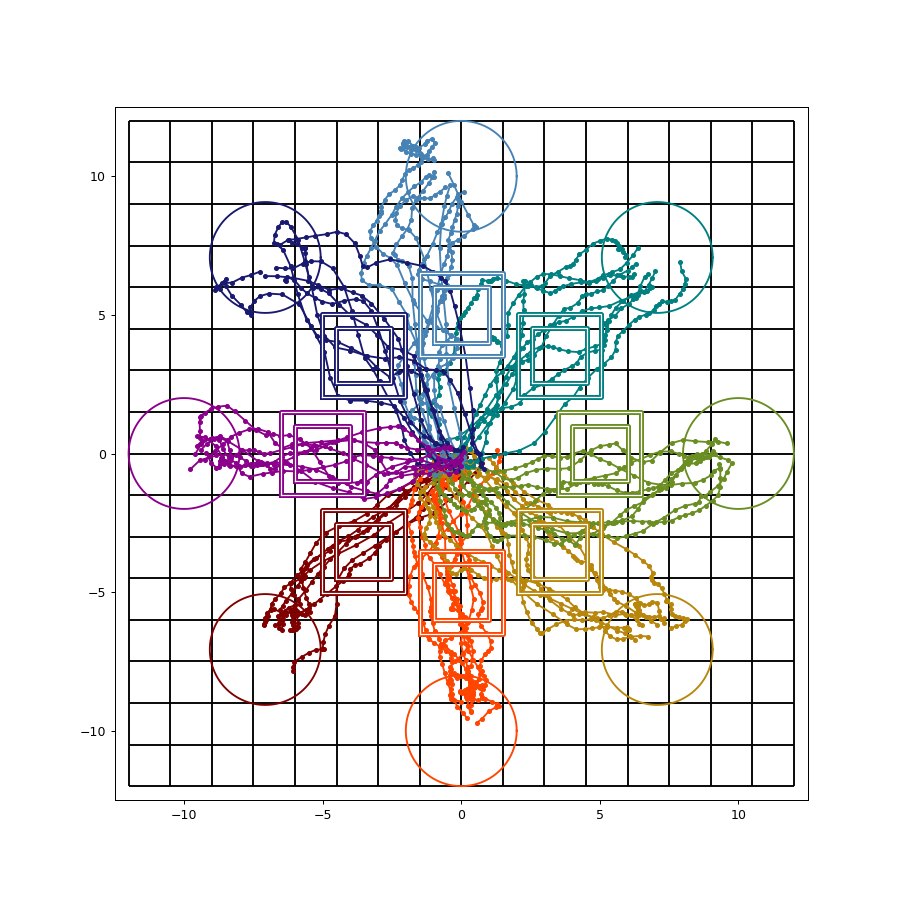

[-7.07106781 -7.07106781]
[-1.8369702e-15 -1.0000000e+01]
[ 7.07106781 -7.07106781]
[10.  0.]
[7.07106781 7.07106781]
[6.123234e-16 1.000000e+01]
[-7.07106781  7.07106781]
[-1.0000000e+01  1.2246468e-15]


<IPython.core.display.Javascript object>


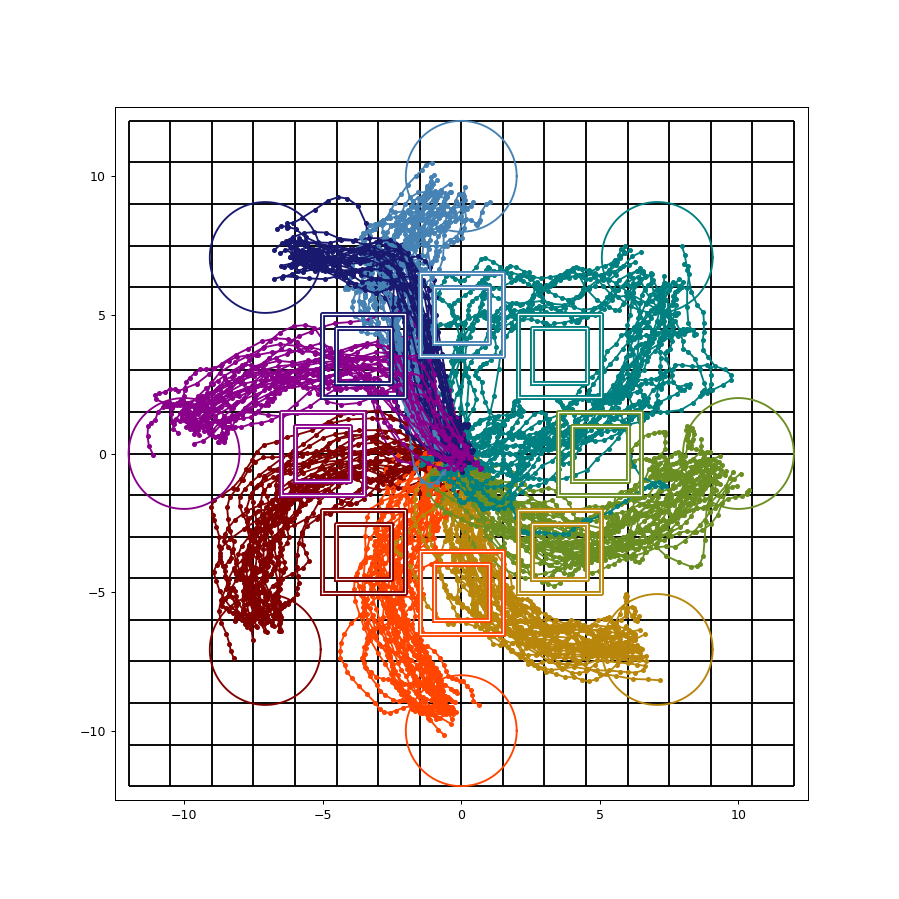

[-7.07106781 -7.07106781]
[-1.8369702e-15 -1.0000000e+01]
[ 7.07106781 -7.07106781]
[10.  0.]
[7.07106781 7.07106781]
[6.123234e-16 1.000000e+01]
[-7.07106781  7.07106781]
[-1.0000000e+01  1.2246468e-15]


In [41]:
#Plot all trials: 
plot_target = True
plot_obs_big = True
plot_obs_small = True

prefix_len = 10

target_black = ['k' for i in range(num_targets)]

plot = {}
plot['task'] = ['co', 'obs']
plot['target'] = range(num_targets)
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)

#Grid lines for binning data: 
#--------------------------------------------------------
plot_grid = True
delta = 1.5
xlim = np.array([-12.0, 12.0])
ylim = np.array([-12.0, 12.0])
h = ylim[1]-ylim[0]
w = xlim[1]-xlim[0]
xg = np.arange(xlim[0], xlim[1]+1, delta)
yg = np.arange(ylim[0], ylim[1]+1, delta)


#Plot target + obstacle
#--------------------------------------------------------
tc = task2tc['obs'][0]
obs_pos = tc_meta[tc]['obs_pos']
obs_big = 3
obs_small = 2
target_pos = tc_meta[tc]['target_pos']
target_r = 2



#Plotting
#--------------------------------------------------------
for task in plot['task']:
    plt.figure(figsize=plot['size'])
    
    for tc in task2tc[task]: 
        for target in plot['target']:
            for trial in tc_meta[tc]['target_trial_idxs'][target]:
                d = tc_trials[tc][trial]['cursor_pos']
                x = d[prefix_len:,0]
                y = d[prefix_len:,1]
                color = target_color[target]
                plt.plot(x,y,'.-',color=color)  
    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r*np.ones(num_targets))  
    if plot_grid:
        plt.vlines(xg, ylim[0], ylim[1])
        plt.hlines(yg, xlim[0], xlim[1])
        
    plt.axis('square')
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()

In [35]:


print(x)
print(y)

[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.]
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.]


<IPython.core.display.Javascript object>


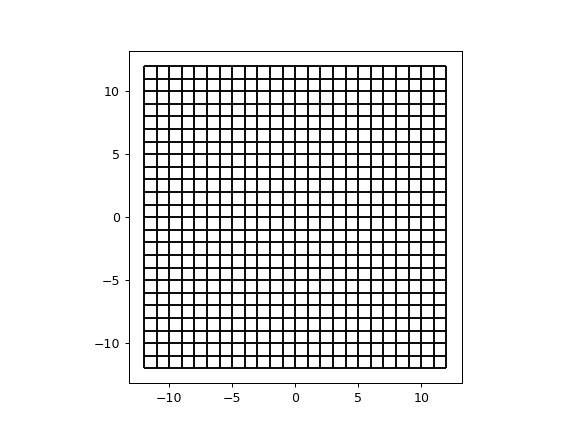

(-13.2, 13.2, -13.2, 13.2)

In [37]:
plt.figure(figsize=)
plt.vlines(x, ylim[0], ylim[1])
plt.hlines(y, xlim[0], xlim[1])
plt.axis('square')

<IPython.core.display.Javascript object>


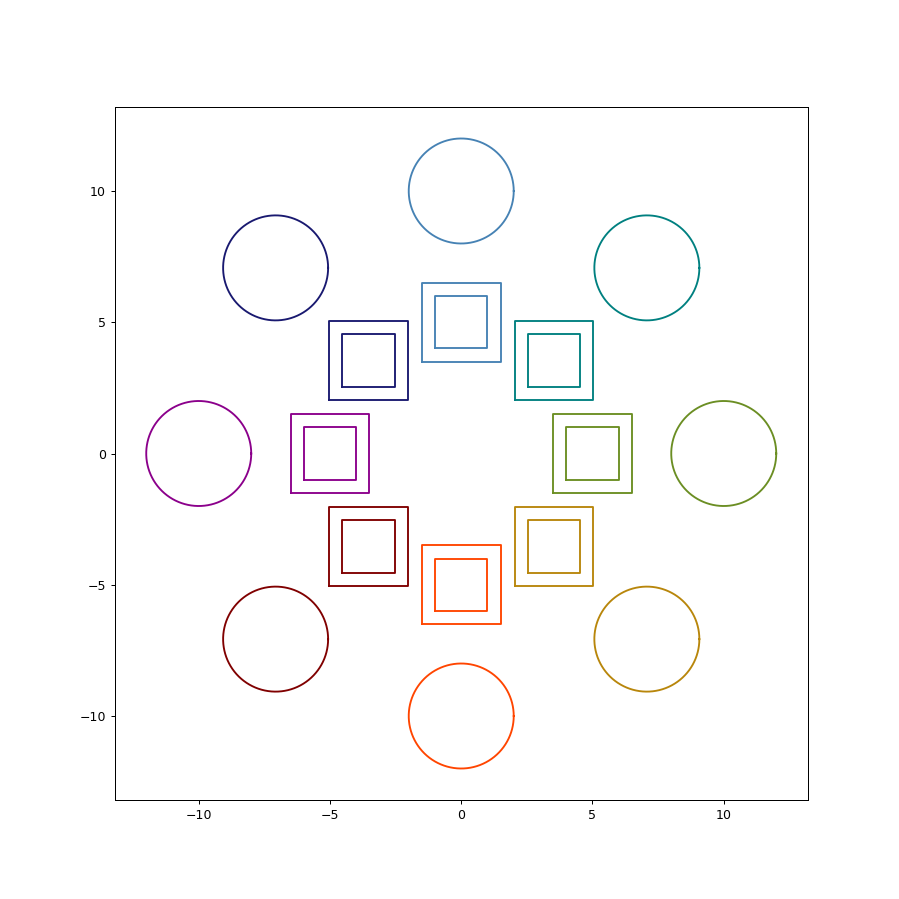

[-7.07106781 -7.07106781]
[-1.8369702e-15 -1.0000000e+01]
[ 7.07106781 -7.07106781]
[10.  0.]
[7.07106781 7.07106781]
[6.123234e-16 1.000000e+01]
[-7.07106781  7.07106781]
[-1.0000000e+01  1.2246468e-15]


In [117]:
#PLOT OBS, TARGET
tc = task2tc['obs'][0]
obs_pos = tc_meta[tc]['obs_pos']
obs_big = 3
obs_small = 2
target_pos = tc_meta[tc]['target_pos']
target_r = 2

plt.figure(figsize=(10,10))
# plt.scatter(obs_pos[:,0], obs_pos[:,1])
# plt.scatter(target_pos[:,0], target_pos[:,1])

bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
bmi_util.plot_targets(target_pos, target_color, target_r*np.ones(num_targets))
z=plt.axis('square')

In [27]:
tc_trials[tc][trial].keys()

['cursor_state',
 'neural_push',
 'len',
 'obstacle_location',
 'binned_spk_cnts',
 'cursor_pos',
 'obstacle_size']

In [52]:
sim['c_t'][-1,:]

array([-6.50308746,  0.        , -5.58939938,  0.27455027,  0.        ,
        1.451134  ,  1.        ])

In [49]:
sim['c_t'].shape

(45L, 7L)

In [58]:
sim['r'].shape
sel = 7
print(sim['c_t'][sel,:])
print(sim['r'][sel,:])

[-0.12135976  0.         -0.10953048 -1.01907914  0.         -1.09622486
  1.        ]
[ 5.56187618  0.         -6.8891201  -1.01907914  0.         -1.09622486
  1.        ]


In [57]:
for i in range(sim['c_t'].shape[0]):
    print(i)
    print(np.allclose(sim['r'][i,:], sim['c_t'][i,:]))

0
True
1
True
2
True
3
True
4
True
5
True
6
True
7
False
8
False
9
True
10
True
11
True
12
True
13
True
14
True
15
True
16
True
17
True
18
True
19
True
20
True
21
True
22
True
23
True
24
True
25
True
26
True
27
True
28
True
29
True
30
True
31
True
32
True
33
True
34
True
35
True
36
True
37
True
38
True
39
True
40
True
41
True
42
True
43
True
44
True


In [47]:
sim.keys()

['n_t', 'r', 'c_t', 'decoder', 'c_tm1', 'r_kn', 'r_d']

F_hat close to F
K_hat close to K
(45L, 7L)
(45L, 7L)
(45L, 7L)
(45L, 7L)
(45L, 7L)
(45L, 7L)
(45L, 7L)
(45L, 7L)
(45L, 7L)
FAIL reconstruction
('time elapsed', 0.00961739999911515)


<IPython.core.display.Javascript object>


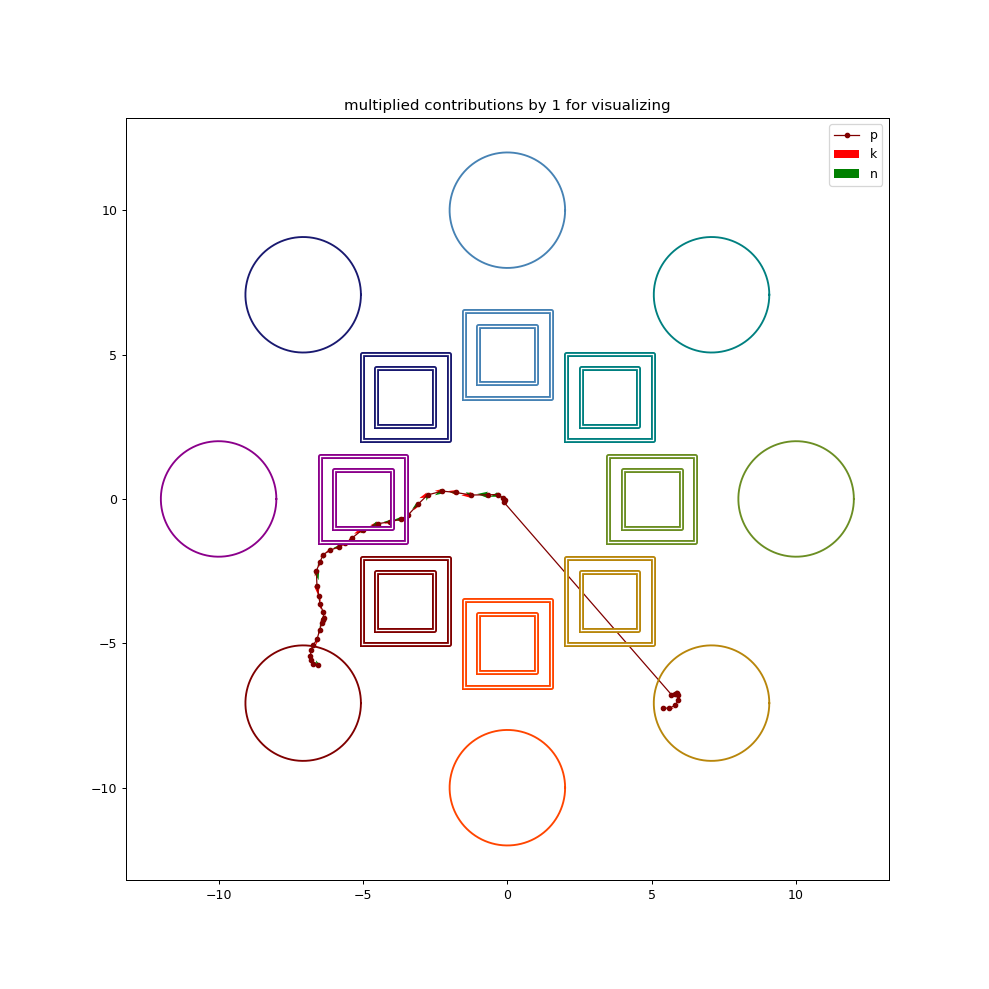

[-7.07106781 -7.07106781]
[-1.8369702e-15 -1.0000000e+01]
[ 7.07106781 -7.07106781]
[10.  0.]
[7.07106781 7.07106781]
[6.123234e-16 1.000000e+01]
[-7.07106781  7.07106781]
[-1.0000000e+01  1.2246468e-15]


Text(0.5,1,'multiplied contributions by 1 for visualizing')

In [43]:
#SIMULATE AND PLOT INDIVIDUAL TRIALS!

#NOTE: simulation will fail on the very first trial because the decoder hasn't converged yet.
#HOWEVER, convergence happens after the first trial.
task = 'obs'
tc = task2tc[task][0]
trial = 9
target = tc_meta[tc]['ttype'][trial]
cursor_state_in = tc_trials[tc][trial]['cursor_state']
spk_cnts = tc_trials[tc][trial]['binned_spk_cnts']

t_start = timeit.default_timer()
F = data[tc, 'decF']
K = data[tc, 'dec_KG']
sim = bmi_util.sim_bmi(cursor_state_in, spk_cnts, F, K)
t_elapsed = timeit.default_timer()-t_start
print('time elapsed', t_elapsed)


#PLOT TRIALS
#-----------------------------------------------------------------------------------------------------------------------
plot = {}
plot['xlim'] = (-10,10)
plot['ylim'] = (-10,10)
plot['size'] = (11,11)
plot['width'] = 0.005 #0.005
p_c_gain = 1
p = sim['c_tm1'][:,sim['decoder']['var_idxs']['p']]
#Position update: 
in_var = ['k', 'n']
plt.figure(figsize=plot['size'])
#Quiver the contributions: 
o = 'p'
var_color = {'p':'b', 'v':'r', 'o':'y', 'n':'g', 'k':'r'}
plt.plot(p[:,0], p[:,1], '.-',color=target_color[target], label='p', linewidth=1, markersize=7)
p_c_sum = np.zeros(p.shape) #sum of the contributions
for i in in_var:
    p_c = sim['r_kn'][o][i]
    if (i=='k'):
        p_c = p_c - sim['r_d'][o]['p']
    p_c = p_c[:,sim['decoder']['var_idxs']['p']]
    
    p_c_plt = p_c_gain*p_c
    plt.quiver(p[:,0], p[:,1], p_c_plt[:,0], p_c_plt[:,1], angles='xy', scale=1, scale_units='xy', width=plot['width'], color=var_color[i], label=i)
    p_c_sum += p_c
# plt.quiver(p[:,0], p[:,1], p_c_sum[:,0], p_c_sum[:,1], angles='xy', scale=1, scale_units='xy', width=plot['width'], color='k', label='sum')
plt.legend()
if plot_obs_small:
    bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
if plot_obs_big:
    bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
if plot_target: 
    bmi_util.plot_targets(target_pos, target_color, target_r*np.ones(num_targets)) 
plt.axis('square')
# plt.xlim(plot['xlim'])
# plt.ylim(plot['ylim'])
plt.title('multiplied contributions by ' + str(p_c_gain) + ' for visualizing')

In [ ]:
#Show's offset, velocity, neural contributions to position: 

plot = {}
plot['xlim'] = (-10,10)
plot['ylim'] = (-10,10)
plot['size'] = (10,10)
p = sim['c_tm1'][:,sim['decoder']['var_idxs']['p']]
#Position update: 
in_var = ['o', 'v', 'n']
plt.figure(figsize=plot['size'])
#Quiver the contributions: 
o = 'p'
i_list = ['v', 'o', 'n']
var_color = {'p':'b', 'v':'r', 'o':'y', 'n':'g'}
plt.plot(p[:,0], p[:,1], '.-',color=target_color[target], label='p', linewidth=1, markersize=7)
p_c_sum = np.zeros(p.shape) #sum of the contributions
for i in in_var:
    p_c = sim['r_d'][o][i][:,sim['decoder']['var_idxs']['p']]
    plt.quiver(p[:,0], p[:,1], p_c[:,0], p_c[:,1], angles='xy', scale=1, scale_units='xy', width=0.005, color=var_color[i], label=i)
    p_c_sum += p_c
plt.quiver(p[:,0], p[:,1], p_c_sum[:,0], p_c_sum[:,1], angles='xy', scale=1, scale_units='xy', width=0.005, color='k', label='sum')
plt.legend()
plt.axis('square')
plt.xlim(plot['xlim'])
plt.ylim(plot['ylim'])

###  Code written during debugging: 

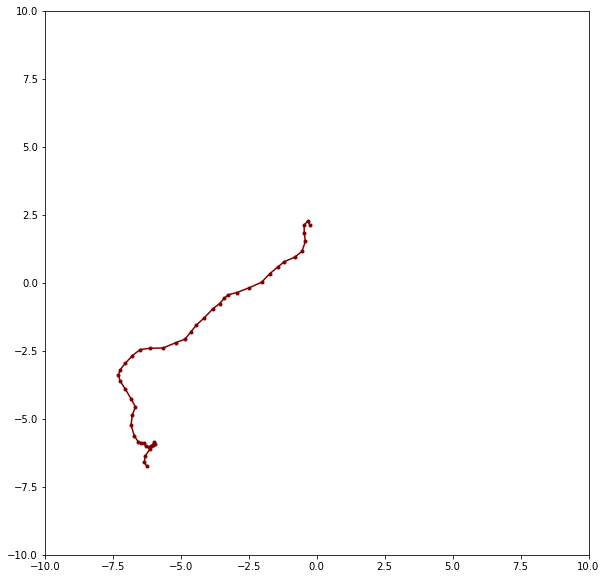

In [10]:
#Plot individual trials within tc, target: 
plot = {}
plot['tc'] = [4377]
plot['target'] = [0]
plot['trial'] = [0]
plot['target'] = range(0+1)
plot['size'] = (10,10)
plot['xlim'] = (-10,10)
plot['ylim'] = (-10,10)

plt.figure(figsize=plot['size'])
for tc in plot['tc']:     
    for target in plot['target']:
        trial_list = tc_meta[tc]['target_trial_idxs'][target][plot['trial']]
        for trial in trial_list: 
            d = tc_trials[tc][trial]['cursor_pos']
            x = d[:,0]
            y = d[:,1]
            color = target_color[target]
            plt.plot(x,y,'.-',color=color)      
    plt.axis('square')
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()

In [12]:
#Test the quiver plot:
test_quiver = False
if test_quiver: 
    plot = {}
    plot['xlim'] = (-3,3)
    plot['ylim'] = (-3,3)
    x_pos = np.array([0])
    y_pos = np.array([0])
    x_vec = np.array([1])
    y_vec = np.array([-3])

    plt.figure(figsize=(10,5))
    plt.quiver(x_pos, y_pos, x_vec, y_vec, angles='xy', scale=1, scale_units='xy', width=0.005*2)
    plt.axis('square')
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])

[[ 1.          0.          0.          0.07        0.          0.
   0.01767333]
 [ 0.          1.          0.          0.          0.07        0.
   0.        ]
 [ 0.          0.          1.          0.          0.          0.07
  -0.01161837]
 [ 0.          0.          0.          0.5         0.          0.
   0.17673329]
 [ 0.          0.          0.          0.          0.5         0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.5
  -0.11618373]
 [ 0.          0.          0.          0.          0.          0.
   1.        ]]


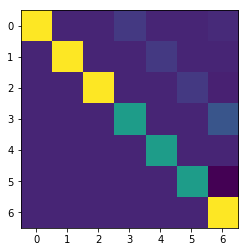

In [13]:
mat = data[tc, 'decF']
plt.figure()
plt.imshow(mat)
print(mat)

<IPython.core.display.Javascript object>


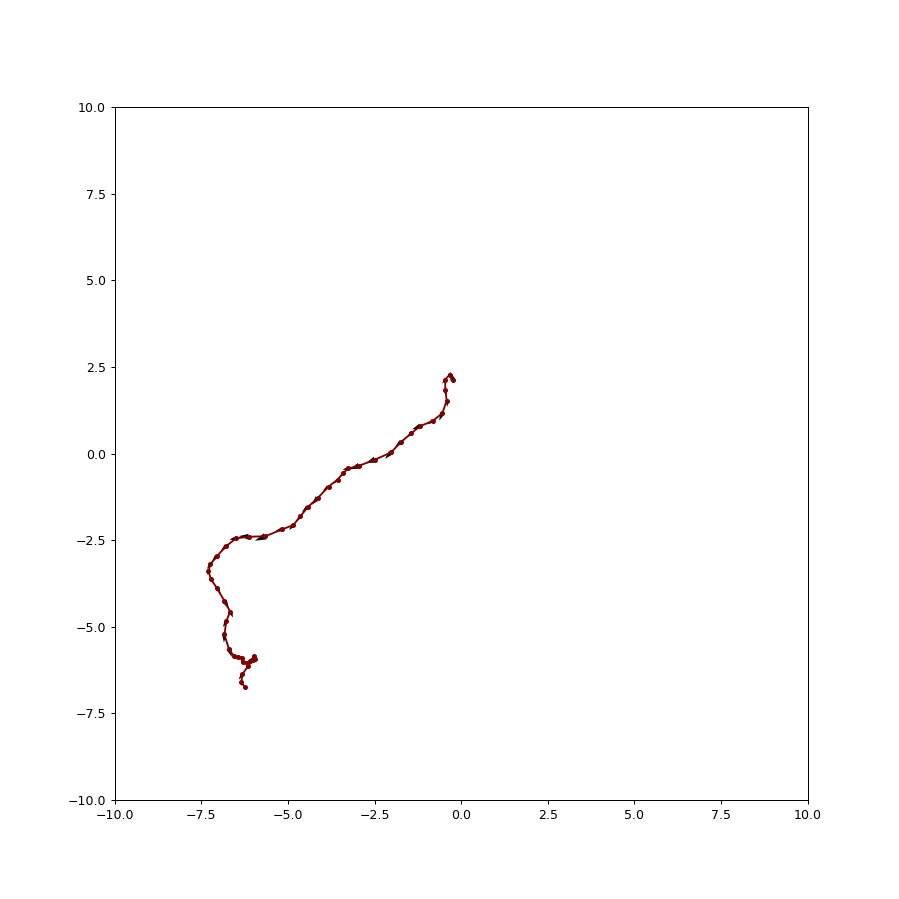

(-10, 10)

In [163]:
#Plot position and velocity trajectory: 
plot = {}
plot['xlim'] = (-10,10)
plot['ylim'] = (-10,10)

tc = task2tc['co'][0]
target = 0
trial = 0

delT = 0.07 #time.  v*delT = position update

d = tc_trials[tc][trial]['cursor_state']
x_pos = d[:,0]
y_pos = d[:,1]
x_vel = d[:,2]*delT
y_vel = d[:,3]*delT

plt.figure(figsize=(10,10))
plt.quiver(x_pos, y_pos, x_vel, y_vel, angles='xy', scale=1, scale_units='xy', width=0.005)
plt.plot(x_pos,y_pos,'.-',color=target_color[target]) 
plt.axis('square')
plt.xlim(plot['xlim'])
plt.ylim(plot['ylim'])


F_hat close to F
K_hat close to K


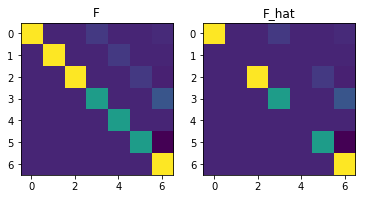

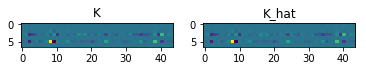

In [14]:
F = data[4377, 'decF']
K = data[4377, 'dec_KG']
decoder = bmi_util.decompose_decoder(F, K)

inspect = True
if inspect: 
    #F:
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(F)
    plt.title('F')

    plt.subplot(1,2,2)
    plt.imshow(decoder['F_hat'])
    plt.title('F_hat')
    
    #K:
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(K)
    plt.title('K')

    plt.subplot(1,2,2)
    plt.imshow(decoder['K_hat'])
    plt.title('K_hat')    

In [ ]:
#I want the individual contributions from each input var
# I also want to group this by: 
# kinematic contribution, neural contribution

In [15]:
task2tc

{'co': [4377], 'obs': [4378, 4382]}

In [18]:
tc_trials[tc][0].keys()

['binned_spk_cnts', 'neural_push', 'cursor_state', 'cursor_pos']

In [89]:
data.keys()

[(4378, 'decC'),
 (4382, 'decW'),
 (4377, 'trial_ix'),
 (4377, 'dec_KG'),
 (4377, 'cursor_state'),
 (4378, 'decQ'),
 (4378, 'dec_KG'),
 (4378, 'target_index'),
 (4377, 'decC'),
 (4378, 'decW'),
 (4378, 'trial_ix'),
 (4377, 'decQ'),
 (4377, 'neural_push'),
 (4377, 'binned_spk_cnts'),
 (4382, 'decQ'),
 (4382, 'dec_KG'),
 (4382, 'decF'),
 (4378, 'cursor_state'),
 (4382, 'binned_spk_cnts'),
 (4378, 'decA'),
 (4382, 'target_pos'),
 (4377, 'decF'),
 (4382, 'decC'),
 'task_entries',
 (4382, 'target_index'),
 (4378, 'cursor_pos'),
 (4382, 'neural_push'),
 (4377, 'decA'),
 (4377, 'target_index'),
 (4382, 'trial_ix'),
 (4378, 'decF'),
 (4377, 'cursor_pos'),
 (4377, 'target_pos'),
 (4382, 'cursor_pos'),
 (4377, 'decW'),
 (4378, 'neural_push'),
 (4382, 'cursor_state'),
 (4378, 'binned_spk_cnts'),
 (4382, 'decA'),
 (4378, 'target_pos')]

In [285]:
sim.keys()

['n_t', 'r', 'c_t', 'decoder', 'c_tm1', 'r_d', 'r_kin_neural']

In [287]:
sim['c_tm1'].shape

(45L, 7L)

In [290]:
sim['decoder']['var_idxs']['p']#.keys()

[0, 2]

In [ ]:
pos.shape

In [304]:
sim.keys()

['n_t', 'r', 'c_t', 'decoder', 'c_tm1', 'r_d', 'r_kin_neural']

In [306]:
sim['r_d'].keys()

['p', 'o', 'v']

In [308]:
sim['r_d']['p']['v'].shape

(45L, 7L)

In [302]:
sim['decoder'].keys()

['F_d', 'var_idxs', 'F', 'K', 'K_hat', 'F_hat', 'out_var', 'K_d', 'out_idxs']

In [303]:
list(sim['decoder']['var_idxs'].keys())

['p', 'n', 'o', 'v']

In [ ]:
sim[]

In [312]:
p.shape

(45L, 2L)

In [ ]:
#plot the sum of contributions

#DONE: 
#confirm that r_pp is just position

In [315]:
pp = sim['r_d']['p']['p'][:,sim['decoder']['var_idxs']['p']]
pp.shape

(45L, 2L)

<IPython.core.display.Javascript object>


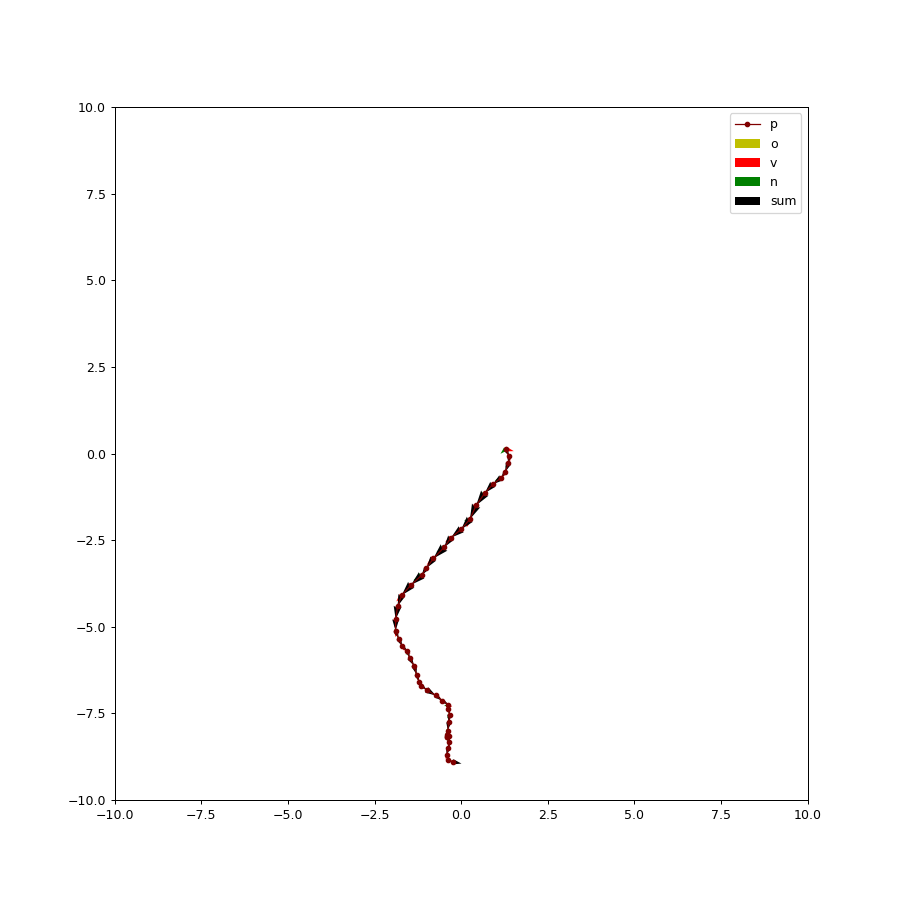

(-10, 10)

In [41]:
plot = {}
plot['xlim'] = (-10,10)
plot['ylim'] = (-10,10)
plot['size'] = (10,10)
p = sim['c_tm1'][:,sim['decoder']['var_idxs']['p']]
#Position update: 
in_var = ['o', 'v', 'n']
plt.figure(figsize=plot['size'])
#Quiver the contributions: 
o = 'p'
i_list = ['v', 'o', 'n']
var_color = {'p':'b', 'v':'r', 'o':'y', 'n':'g'}
plt.plot(p[:,0], p[:,1], '.-',color=target_color[target], label='p', linewidth=1, markersize=7)
p_c_sum = np.zeros(p.shape) #sum of the contributions
for i in in_var:
    p_c = sim['r_d'][o][i][:,sim['decoder']['var_idxs']['p']]
    plt.quiver(p[:,0], p[:,1], p_c[:,0], p_c[:,1], angles='xy', scale=1, scale_units='xy', width=0.005, color=var_color[i], label=i)
    p_c_sum += p_c
plt.quiver(p[:,0], p[:,1], p_c_sum[:,0], p_c_sum[:,1], angles='xy', scale=1, scale_units='xy', width=0.005, color='k', label='sum')
plt.legend()
plt.axis('square')
plt.xlim(plot['xlim'])
plt.ylim(plot['ylim'])

In [26]:
data.keys()

[(4378, 'decC'),
 (4382, 'decW'),
 (4377, 'trial_ix'),
 (4377, 'dec_KG'),
 (4377, 'cursor_state'),
 (4378, 'decQ'),
 (4378, 'dec_KG'),
 (4378, 'target_index'),
 (4377, 'decC'),
 (4378, 'decW'),
 (4378, 'trial_ix'),
 (4377, 'decQ'),
 (4377, 'neural_push'),
 (4377, 'binned_spk_cnts'),
 (4382, 'decQ'),
 (4382, 'dec_KG'),
 (4382, 'decF'),
 (4378, 'cursor_state'),
 (4382, 'binned_spk_cnts'),
 (4378, 'decA'),
 (4382, 'target_pos'),
 (4377, 'decF'),
 (4382, 'decC'),
 'task_entries',
 (4382, 'target_index'),
 (4378, 'cursor_pos'),
 (4382, 'neural_push'),
 (4377, 'decA'),
 (4377, 'target_index'),
 (4382, 'trial_ix'),
 (4378, 'decF'),
 (4377, 'cursor_pos'),
 (4377, 'target_pos'),
 (4382, 'cursor_pos'),
 (4377, 'decW'),
 (4378, 'neural_push'),
 (4382, 'cursor_state'),
 (4378, 'binned_spk_cnts'),
 (4382, 'decA'),
 (4378, 'target_pos')]

In [29]:
sim['decoder']['var_idxs']['p']

[0, 2]

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


<IPython.core.display.Javascript object>


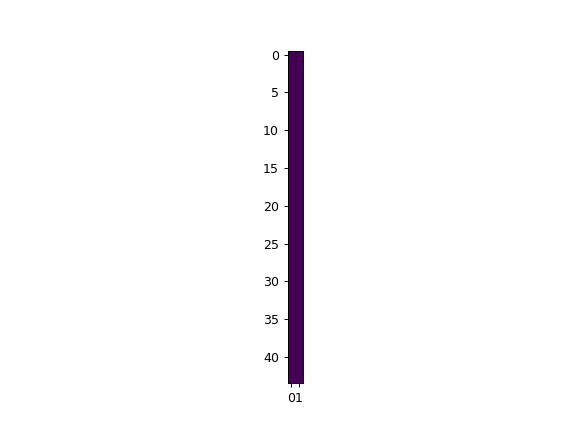

In [31]:
#Confirm that decoder doesn't model the tuning of neural activity to position of the cursor: 

C_p2n = data[4377, 'decC'][:,sim['decoder']['var_idxs']['p']]
print(C_p2n)
plt.figure()
plt.imshow(C_p2n)


In [314]:
sim['r_kin_neural'].keys()

['kin', 'n']

In [ ]:
#TODO: kin vs neural

In [32]:
sim.keys()

['n_t', 'r', 'c_t', 'decoder', 'c_tm1', 'r_d', 'r_kin_neural']

In [34]:
sim['r_kin_neural'].keys()

['kin', 'n']

In [49]:
sim['r_kn']['p']['k'][0:1,:]

array([[1.53249401, 0.        , 0.05682729, 0.        , 0.        ,
        0.        , 0.        ]])

In [52]:
print(sim['r_d']['p']['v'][0:1,:])
print(sim['r_d']['p']['p'][0:1,:])

[[ 0.2374455   0.         -0.06099378  0.          0.          0.
   0.        ]]
[[1.27737518 0.         0.12943944 0.         0.         0.
  0.        ]]


In [55]:
if 5 != 5:
    print('hi')
else: 
    print('wha')

wha


In [57]:
sim['decoder']['K'].shape

(7L, 44L)

In [58]:
sim.keys()

['n_t', 'r', 'c_t', 'decoder', 'c_tm1', 'r_kn', 'r_d']

In [59]:
sim['r'].shape

(45L, 7L)

<IPython.core.display.Javascript object>


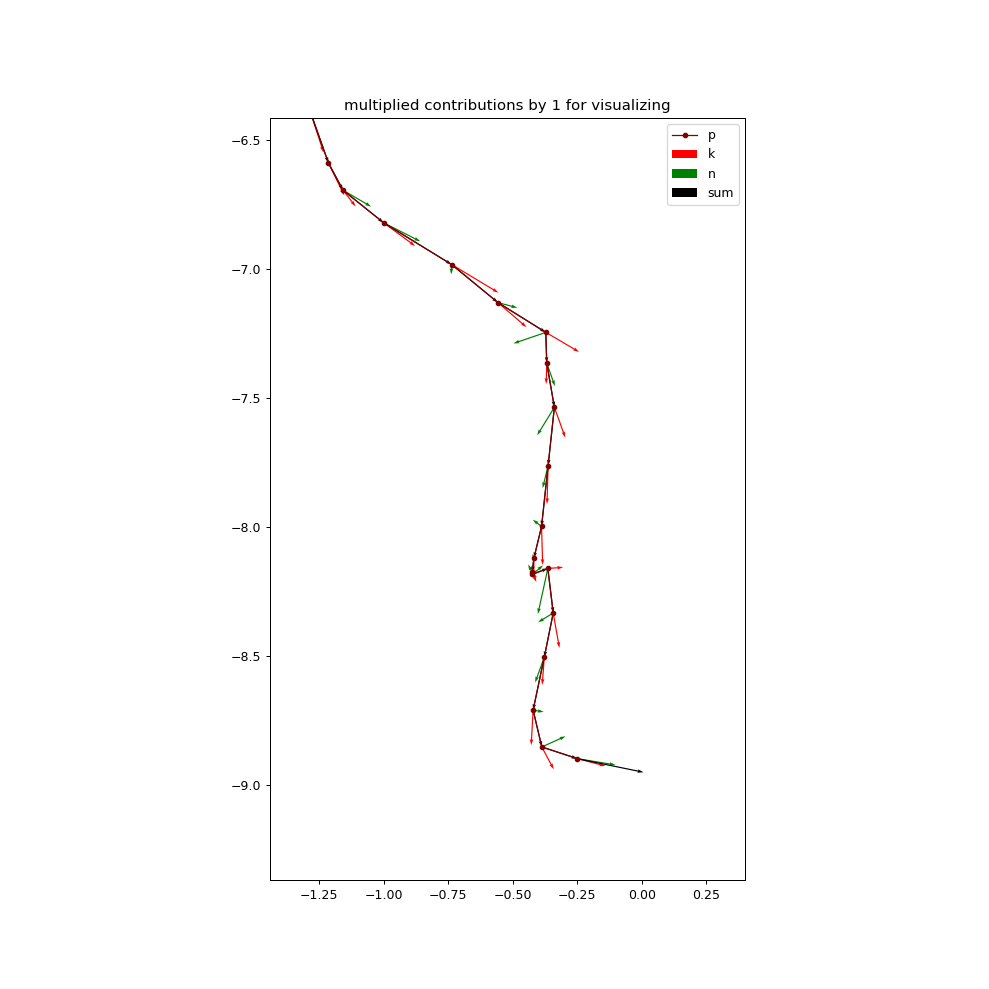

Text(0.5,1,'multiplied contributions by 1 for visualizing')

In [67]:
plot = {}
plot['xlim'] = (-10,10)
plot['ylim'] = (-10,10)
plot['size'] = (11,11)
plot['width'] = 0.0025 #0.005
p_c_gain = 1
p = sim['c_tm1'][:,sim['decoder']['var_idxs']['p']]
#Position update: 
in_var = ['k', 'n']
plt.figure(figsize=plot['size'])
#Quiver the contributions: 
o = 'p'
var_color = {'p':'b', 'v':'r', 'o':'y', 'n':'g', 'k':'r'}
plt.plot(p[:,0], p[:,1], '.-',color=target_color[target], label='p', linewidth=1, markersize=7)
p_c_sum = np.zeros(p.shape) #sum of the contributions
for i in in_var:
    p_c = sim['r_kn'][o][i]
    if (i=='k'):
        p_c = p_c - sim['r_d'][o]['p']
    p_c = p_c[:,sim['decoder']['var_idxs']['p']]
    
    p_c_plt = p_c_gain*p_c
    plt.quiver(p[:,0], p[:,1], p_c_plt[:,0], p_c_plt[:,1], angles='xy', scale=1, scale_units='xy', width=plot['width'], color=var_color[i], label=i)
    p_c_sum += p_c
plt.quiver(p[:,0], p[:,1], p_c_sum[:,0], p_c_sum[:,1], angles='xy', scale=1, scale_units='xy', width=plot['width'], color='k', label='sum')
plt.legend()
plt.axis('square')
plt.xlim(plot['xlim'])
plt.ylim(plot['ylim'])
plt.title('multiplied contributions by ' + str(p_c_gain) + ' for visualizing')

In [42]:
#kin vs neural contribution:
plot = {}
plot['xlim'] = (-10,10)
plot['ylim'] = (-10,10)
plot['size'] = (10,10)

p = sim['c_tm1'][:,sim['decoder']['var_idxs']['p']]
#Position update: 
# in_var = ['o', 'v', 'n']
in_var = 

plt.figure(figsize=plot['size'])
#Quiver the contributions: 
o = 'p'
i_list = ['v', 'o', 'n']

var_color = {'k':'r', 'n':'g'} #{'p':'b', 'v':'r', 'o':'y', 'n':'g'}

p_c_sum = np.zeros(p.shape)
for src in src_var:
    p_c = sim['r_kin_neural'][src][:,sim['decoder']['var_idxs']['p']]
    plt.quiver(p[:,0], p[:,1], p_c[:,0], p_c[:,1], angles='xy', scale=1, scale_units='xy', width=0.005, color=var_color[src], label=src)
    p_c_sum += p_c
    
plt.plot(p[:,0], p[:,1], '.-',color=target_color[target], label='p')
plt.legend()
#plot the position. 
#whisker: 
#o, v, n

plt.axis('square')
plt.xlim(plot['xlim'])
plt.ylim(plot['ylim'])

<IPython.core.display.Javascript object>

TypeError: unhashable type

In [ ]:
#what is the alignment of the position readout and velocity readout? 

In [323]:
decoder['K_d']['p']

array([[ 0.00310474,  0.00558691, -0.03375699, -0.02331667, -0.00871883,
         0.00052042, -0.0038834 ,  0.00609111, -0.00977743,  0.01506697,
        -0.03012991,  0.00040889, -0.00021649, -0.0050321 , -0.00048202,
        -0.00378722,  0.01456487,  0.00393823,  0.01229848, -0.00549013,
         0.0026101 , -0.00746249,  0.00496815, -0.00225714, -0.02097607,
         0.00575992, -0.00322054, -0.01148331,  0.00166176,  0.0035875 ,
        -0.00135505,  0.00627183, -0.01189105, -0.01078395, -0.02564555,
        -0.01410075, -0.01316643, -0.00320499,  0.01435392, -0.02837174,
         0.037843  , -0.00894859,  0.00849119,  0.00622661],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.

In [328]:
sim['decoder']['var_idxs']['p']

[0, 2]

In [ ]:
sim['decoder']

In [331]:
#Take the decoder rows, form a matrix, and take the gramian: 
sim['decoder']['K'].shape

ip = sim['decoder']['var_idxs']['p']
iv = sim['decoder']['var_idxs']['v']

Kp = sim['decoder']['K'][ip,:]
Kv = sim['decoder']['K'][iv,:]

dmat = np.vstack((Kp, Kv))

In [334]:
dmat.shape
for i in range(4):
    dmat[i,:] = dmat[i,:]/np.linalg.norm(dmat[i,:])
    

In [335]:
dgram = np.dot(dmat, dmat.T)

<IPython.core.display.Javascript object>


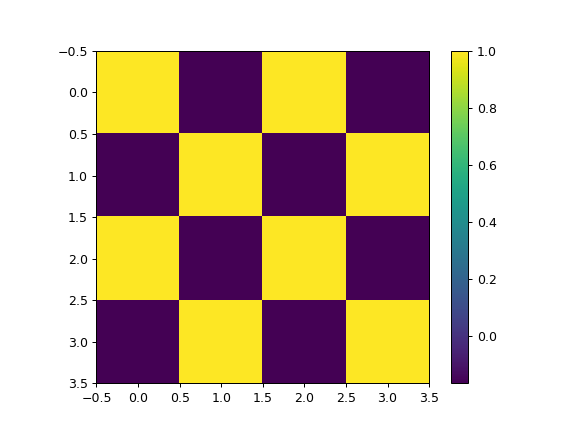

In [339]:
plt.figure()
plt.imshow(dgram)
plt.colorbar()
# plt.axis('square')

In [284]:
sim['r_d']['p']['o'].shape

(45L, 7L)

In [281]:
sim.keys()

['n_t', 'r', 'c_t', 'decoder', 'c_tm1', 'r_d', 'r_kin_neural']

In [282]:
sim['r_d']

{'o': {'n': array([[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0

<IPython.core.display.Javascript object>


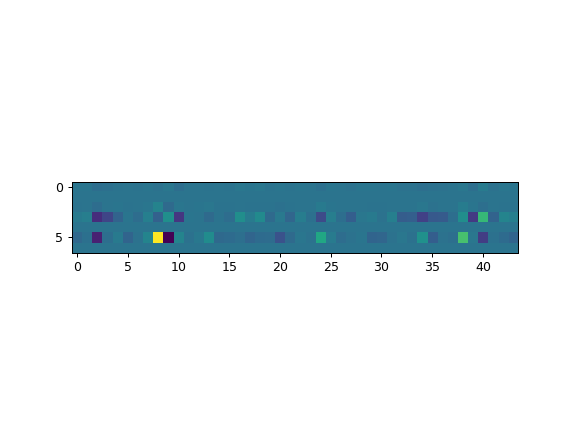

<IPython.core.display.Javascript object>


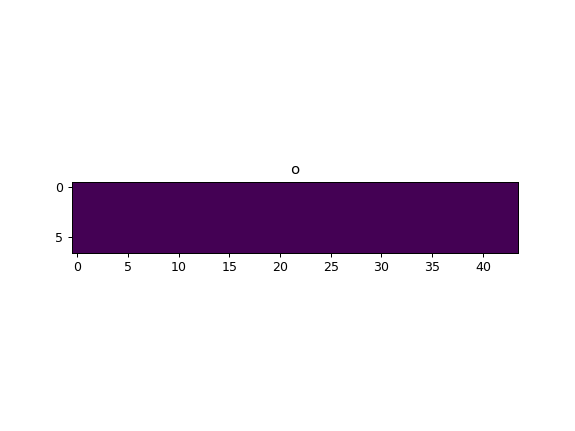

<IPython.core.display.Javascript object>


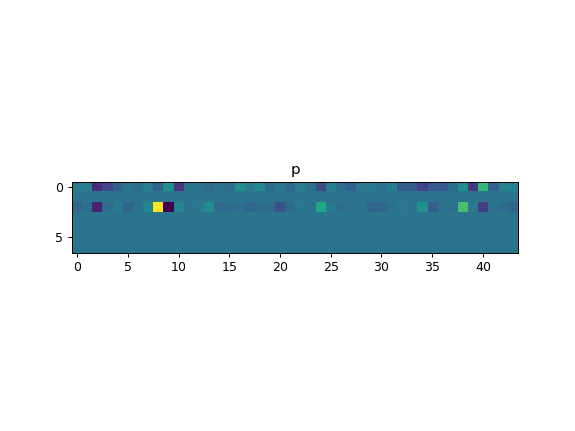

<IPython.core.display.Javascript object>


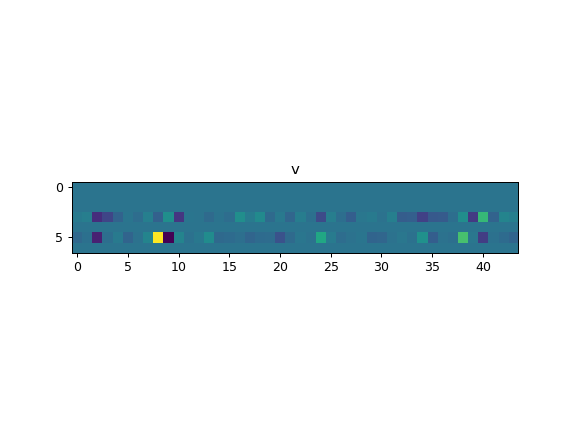

In [261]:
plt.figure()
plt.imshow(sim['decoder']['K'])

for v in sim['decoder']['out_var']:    
    plt.figure()
    plt.imshow(sim['decoder']['K_d'][v])
    plt.title(v)

In [238]:
sim['decoder']['out_var']
sim['decoder']['out_idxs']

[0, 2, 3, 5, 6]

In [240]:
sel = 0
sim['r'][sel,:]

array([-0.3311624 ,  0.        ,  2.22996456, -0.66991592,  0.        ,
        0.40551676,  1.        ])

In [241]:
sim['c_t'][sel,:]

array([-0.33694862,  0.        ,  2.27200813, -0.67147976,  0.        ,
        0.41687989,  1.        ])

In [230]:
sim['c_current'].shape

(49L, 7L)

In [ ]:
np.array([1,1,1])/np.array([1.0,2.0,3.0])

In [195]:
data[tc, 'cursor_state'][0].shape

(50L, 4L)

In [196]:
data[tc, 'spk_cnts'][0].shape

KeyError: (4377, 'spk_cnts')

In [181]:
F_hat

array([[ 1.        ,  0.        ,  0.        ,  0.07      ,  0.        ,
         0.        ,  0.01767333],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.07      , -0.01161837],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.        ,
         0.        ,  0.17673329],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.5       , -0.11618373],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ]])

In [182]:
F

array([[ 1.        ,  0.        ,  0.        ,  0.07      ,  0.        ,
         0.        ,  0.01767333],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.07      ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.07      , -0.01161837],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.        ,
         0.        ,  0.17673329],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.5       ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.5       , -0.11618373],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ]])

In [183]:
F_hat-F

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.  ,  0.  ,  0.  , -0.07,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.5 ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])